In [5]:
%matplotlib inline

import gym
import itertools
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import sys
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict
from collections import namedtuple
if "../" not in sys.path:
   sys.path.append("../") 
from blackjack_fromgit import BlackjackEnv
#from plotting_fromgit import plot_value_function
from blackjack_env import Simple21
from surface_plot import plottable_3d_info
from plotting_fromgit import EpisodeStats

matplotlib.style.use('ggplot')

#https://github.com/dalmia/David-Silver-Reinforcement-learning/blob/master/Week%205%20-%20Model%20Free%20Control/SARSA.ipynb
#https://github.com/hartikainen/easy21


In [302]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        #print('it is happening after this')
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def get_epsilon(N):
    N_0 = 100
    return N_0/(N_0 + N)

def epsilon_greedy_policy(Q, N, state):
    player, dealer = state
    epsilon = get_epsilon(np.sum(N[player-1, dealer-1]))
    if np.random.rand() < (1 - epsilon):
        action = np.argmax(Q[player-1, dealer-1, :])
    else:
        action = np.random.choice([0,1])
    return action

##############################
#implement SARSA
############################


def sarsa(env, num_episodes, sarsalambda, discount_factor=1.0, epsilon=0.1):
#def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):

    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # Number of actions
    nA = env.action_space.n
    nS = 21*10


    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    #Q = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = np.zeros((21,10,2))
    
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_MSE"])

    # Keeps track of useful statistics
    #stats = plotting.EpisodeStats(
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        episode_MSE=np.zeros(num_episodes))

    # The policy we're following
    #policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    returns_count = np.zeros((21,10,2))
    state_counts = np.zeros((21,10))

    for i_episode in range(num_episodes):
        
        # GLIE criteria
        epsilon /= (i_episode + 1)
        
        # Print out which episode we're on, useful for debugging.
        # if (i_episode + 1) % 100 == 0:
        #     print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes))
        #     sys.stdout.flush()
        
        state = env.reset()
        terminated = False
        eligibility=np.zeros((21,10,2))

        # sample action following epsilon greedy policy
        action = epsilon_greedy_policy(Q,state_counts,state)#np.random.choice(nA, p=policy(state))

        for t in itertools.count():    
    
            
            # Perform the action -> Get the reward and observe the next state 
            new_state, reward, terminated, _ = env.step(action)
            if terminated:
                state = (state[0] - 1,state[1] - 1)
                eligibility[state][action] += 1
                returns_count[state][action] += 1
                state_counts[state] += 1
                Q[state][action] += (reward - Q[state][action])*eligibility[state][action]/returns_count[state][action]
                break
            #print(terminated)
            
            # Choose the action for the next state following our current policy
            new_state = (new_state[0] - 1,new_state[1] - 1)
            next_action = epsilon_greedy_policy(Q,state_counts,new_state)#np.random.choice(nA, p=policy(new_state))
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # value that we should have got
            #new_state = (new_state[0] - 1,new_state[1] - 1)
            state = (state[0] -1, state[1] - 1)
            td_target = reward + discount_factor * Q[new_state][next_action] 
            td_error = td_target - Q[state][action]                        #this is delta from the pseudo code
            
            #eligibility trace
            #Q[state][action] =+ (returns_sum[state][action] - Q[state][action]) / returns_count[state][action]
            
            eligibility[state][action] += 1
            returns_count[state][action] += 1.0 # one over this is the alpha in the pseduo code
            state_counts[state] += 1.0

            MSE=td_error**2
            stats.episode_MSE[i_episode]= MSE

            for s1 in range(Q.shape[0]):
                for s2 in range(Q.shape[1]):
                    s = (s1,s2)
                    for a in range(0,nA):
                        #SARSA update
                        if returns_count[s][a] != 0:
                            Q[s][a] += td_error * eligibility[s][a]/returns_count[s][a]
                            eligibility[s][a]  *= sarsalambda  #gamma is 1 in this example
            # Update current state
            state = new_state
            action = next_action

            if terminated:
                break
    
    return Q, stats,  MSE, sarsalambda, i_episode

In [18]:
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [12]:
#env = BlackjackEnv()
env = Simple21()

In [283]:

#Q, stats = sarsa(env, 2000)
Q, stats , MSE, sarsalambda, i_episode = sarsa(env, 50000,0)
print("lambda: ", sarsalambda, "MSE :", MSE)

lambda:  0 MSE : 0.003717224031753021


In [303]:
checklambdas=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for value in checklambdas:
    Q, stats , MSE, sarsalambda , i_episode= sarsa(env, 1000, value)
    print("lambda: ", sarsalambda, "MSE :", MSE)

lambda:  0 MSE : 0.016650407579210068
lambda:  0.1 MSE : 0.11875497814158494
lambda:  0.2 MSE : 0.3151799725057521
lambda:  0.3 MSE : 0.8711111111111112
lambda:  0.4 MSE : 0.1415006254972523
lambda:  0.5 MSE : 0.054444444444444434
lambda:  0.6 MSE : 0.016748019997959423
lambda:  0.7 MSE : 0.22784342615687458
lambda:  0.8 MSE : 0.015274942107455199
lambda:  0.9 MSE : 0.1465767217616088
lambda:  1 MSE : 0.2589217455689759


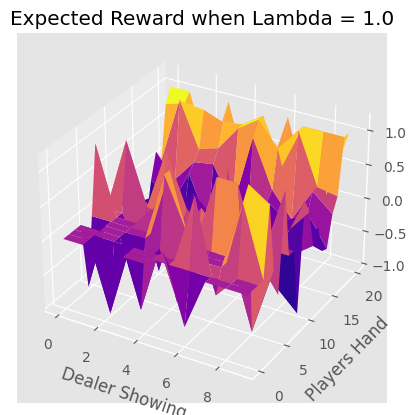

In [297]:
lambdavalue=1
Q, stats , MSE, sarsalambda , i_episode = sarsa(env, 1000, lambdavalue)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some test data.
X = range(0,21)
Y = range(0,10)
X,Y = np.mgrid[X,Y]
Z = np.max(Q,2)

# Plot a basic wireframe.
ax.plot_surface(Y, X, Z,cmap='plasma')
plt.xlabel('Dealer Showing')
plt.ylabel('Players Hand')
plt.title('Expected Reward when Lambda = %1.1f' %lambdavalue)
plt.show()

In [312]:
Q, stats , MSE, sarsalambda , i_episode= sarsa(env, 1000,0.2)
stats.episode_MSE

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [ ]:
stats